In [1]:
import numpy as np
import inspect
from scipy.interpolate import interp1d
from IPython.display import display
from ipywidgets import FloatProgress
from atmos_cloud_sim_uj_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal

from PySDM_examples.UIUC_2021 import make_particulator, run_simulation, \
    make_sampling_plot, make_temperature_plot, make_freezing_spec_plot, make_pdf_plot
from PySDM_examples.UIUC_2021.commons import (
    FREEZING_CONSTANTS, COOLING_RATES, BEST_FIT_LN_S_GEOM, TEMP_RANGE, LOGNORMAL_MODE_SURF_A
)

/home/slayoo/devel/PySDM/PySDM/backends/__init__.py:32: UserWarning: CUDA library found but cuInit() failed (error code: 999; message: unknown error)
  warnings.warn(


In [2]:
constants = FREEZING_CONSTANTS["dust"]

params = {
    'log2_n_sd': 6,
    'n_steps': 60,
    'ensemble_n': 5,
    'drop_v_um3': 3,
    'ln10_drop_n': 15,
    'ln10_vol_m3': 6,
}

formulae = Formulae(
    freezing_temperature_spectrum='Niemand_et_al_2012',
    constants=constants
)

def A_spec(ln_s_geom):
    return Lognormal(norm_factor=1, m_mode=LOGNORMAL_MODE_SURF_A, s_geom=np.exp(ln_s_geom))

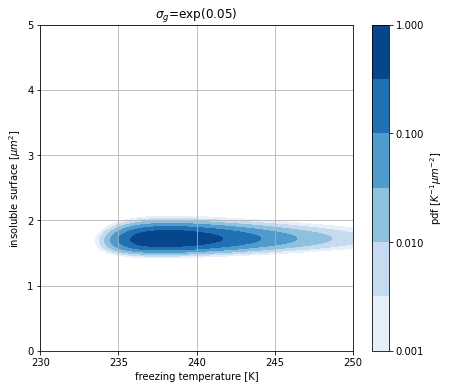

HTML(value="<a href='./fig3_ln_s_geom=0.05.pdf' target='_blank'>./fig3_ln_s_geom=0.05.pdf</a><br>")

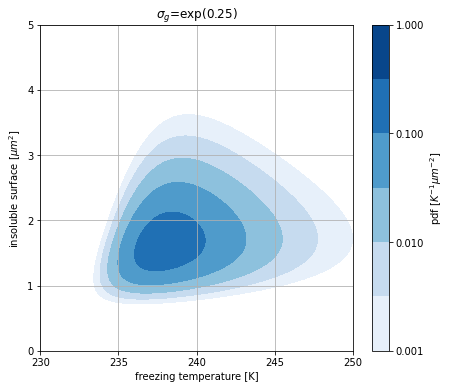

HTML(value="<a href='./fig3_ln_s_geom=0.25.pdf' target='_blank'>./fig3_ln_s_geom=0.25.pdf</a><br>")

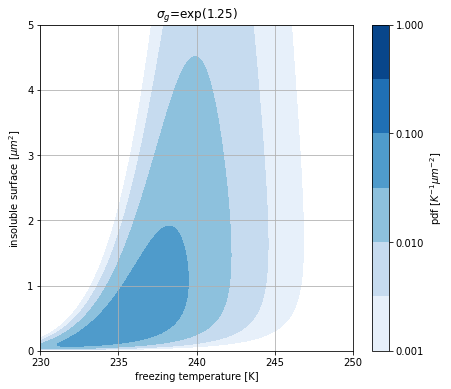

HTML(value="<a href='./fig3_ln_s_geom=1.25.pdf' target='_blank'>./fig3_ln_s_geom=1.25.pdf</a><br>")

In [3]:
for ln_s_geom in (BEST_FIT_LN_S_GEOM/5, BEST_FIT_LN_S_GEOM, BEST_FIT_LN_S_GEOM*5):
    make_pdf_plot(
        A_spec(ln_s_geom),
        formulae.freezing_temperature_spectrum.pdf,
        A_range = (0 * si.um ** 2, 5 * si.um ** 2),
        T_range = TEMP_RANGE
    )
    show_plot(f'fig3_ln_s_geom={ln_s_geom}.pdf')

In [4]:
def run_and_plot(*, 
              log2_n_sd, n_steps, ensemble_n,
              drop_v_um3,
              ln10_drop_n,
              ln10_vol_m3,
              ln_s_geom,
              times,
              temps
             ):
    progbar = FloatProgress(value=0, min=0, max=100, description='%')
    display(progbar)

    progbar.value = 0
    
    temperature_profile = interp1d(
        x=times, 
        y=temps,
        kind='linear',
        fill_value="extrapolate"
    )
    assert temperature_profile.x[0] == 0
    
    params = {
        'droplet_volume': drop_v_um3 * si.um**3,
        'total_particle_number': 10**ln10_drop_n,
        'volume': 10**ln10_vol_m3
    }
    surf_spec=A_spec(ln_s_geom)
    
    output = []
    for singular in (True, False):
        for seed in range(ensemble_n):
            particulator = make_particulator(
                constants=constants,
                n_sd=2**log2_n_sd, 
                dt=temperature_profile.x[-1]/n_steps,
                initial_temperature = temperature_profile(0),
                singular=singular,
                seed=seed,
                shima_T_fz=formulae.freezing_temperature_spectrum.__name__,
                ABIFM_spec=surf_spec,
                **params
            )
            output.append({
                **run_simulation(particulator, temperature_profile, n_steps),
                'singular': singular
            })
            progbar.value += 100/2/ensemble_n

    if len(temperature_profile.x) == 2:
        cooling_rate_K_min = np.diff(temperature_profile.y)[0] / np.diff(temperature_profile.x)[0] / (si.K/si.min)
    else:
        cooling_rate_K_min = 'variable'

    make_freezing_spec_plot(
        output, 
        formulae, 
        surf_spec=surf_spec,
        **params,
        cooling_rate_K_min=cooling_rate_K_min
    )
    show_plot(f'fig2-c={cooling_rate_K_min}_K_per_min-ln_s_geom={ln_s_geom}.pdf')

FloatProgress(value=0.0, description='%')

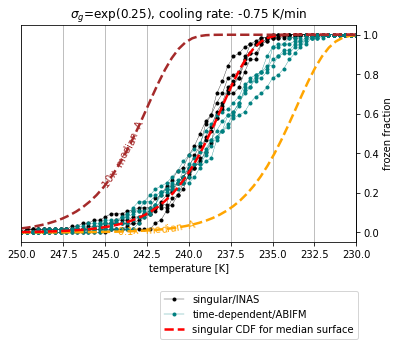

HTML(value="<a href='./fig2-c=-0.75_K_per_min-ln_s_geom=0.25.pdf' target='_blank'>./fig2-c=-0.75_K_per_min-ln_…

FloatProgress(value=0.0, description='%')

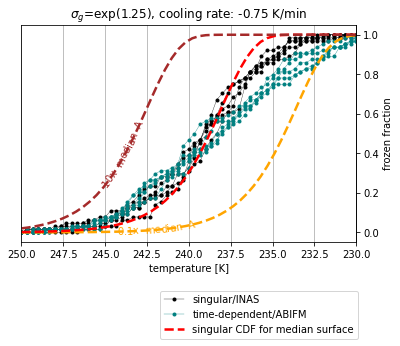

HTML(value="<a href='./fig2-c=-0.75_K_per_min-ln_s_geom=1.25.pdf' target='_blank'>./fig2-c=-0.75_K_per_min-ln_…

FloatProgress(value=0.0, description='%')

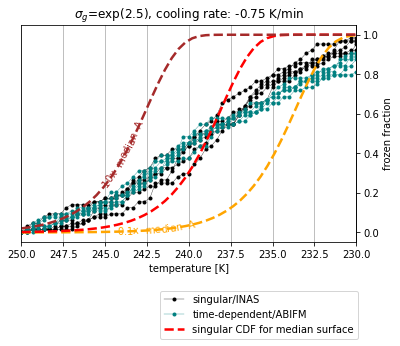

HTML(value="<a href='./fig2-c=-0.75_K_per_min-ln_s_geom=2.5.pdf' target='_blank'>./fig2-c=-0.75_K_per_min-ln_s…

In [5]:
assert len(COOLING_RATES) == 3
base_cooling_rate = COOLING_RATES[1]
dT = TEMP_RANGE[0] - TEMP_RANGE[1]

for ln_s_geom in (BEST_FIT_LN_S_GEOM, 5*BEST_FIT_LN_S_GEOM, 10*BEST_FIT_LN_S_GEOM):    
    run_and_plot(
        **params,
        ln_s_geom=ln_s_geom,
        times=np.asarray([0, dT / base_cooling_rate]),
        temps=np.asarray(list(TEMP_RANGE))
    )

FloatProgress(value=0.0, description='%')

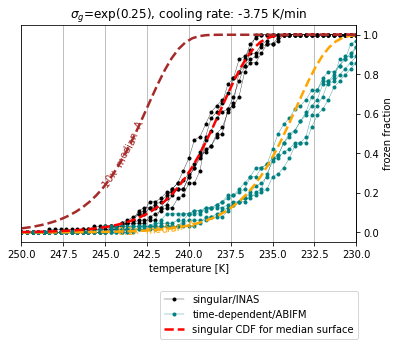

HTML(value="<a href='./fig2-c=-3.75_K_per_min-ln_s_geom=0.25.pdf' target='_blank'>./fig2-c=-3.75_K_per_min-ln_…

FloatProgress(value=0.0, description='%')

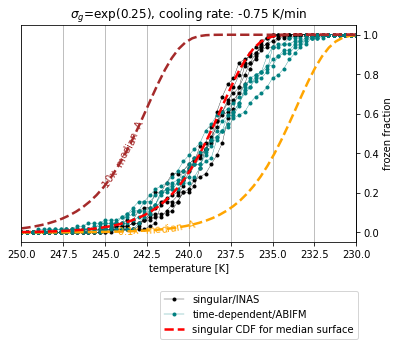

HTML(value="<a href='./fig2-c=-0.75_K_per_min-ln_s_geom=0.25.pdf' target='_blank'>./fig2-c=-0.75_K_per_min-ln_…

FloatProgress(value=0.0, description='%')

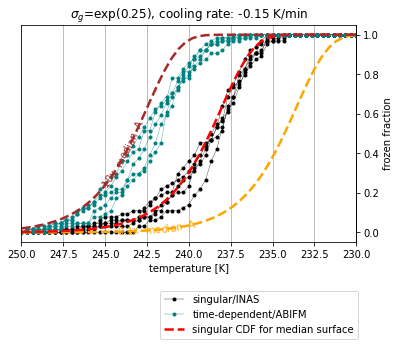

HTML(value="<a href='./fig2-c=-0.15_K_per_min-ln_s_geom=0.25.pdf' target='_blank'>./fig2-c=-0.15_K_per_min-ln_…

In [6]:
for cooling_rate in COOLING_RATES:
    run_and_plot(
        **params,
        ln_s_geom=BEST_FIT_LN_S_GEOM,
        times=np.asarray([0, dT / cooling_rate]),
        temps=np.asarray(list(TEMP_RANGE))
    )